<a href="https://colab.research.google.com/github/jiheddachraoui/occupancy_grid_generator/blob/main/OG_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREPARATION

In [ ]:
import os
import sys
import csv
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from sklearn.linear_model import RANSACRegressor
from scipy import stats
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
### Load carla data
datadir = '/content/drive/MyDrive/s_data/'
scenario='scenarios/scenario_test2'
gt='ground truth/scenario_test2_gt'
vehicle='adversary vehicle.tesla.model3'

folder_path = os.path.join(datadir,scenario,vehicle)
gt_path=os.path.join(datadir,gt,vehicle)
print(folder_path)


/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3


In [ ]:
def get_subfolders(path):

    subfolders = [os.path.join(path, d) for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    result = []
    for subfolder in subfolders:
        sub_subfolders = get_subfolders(subfolder)
        if not sub_subfolders:
            result.append(subfolder)
        else:
            result.extend(sub_subfolders)
    return result

In [ ]:
subfolders = get_subfolders(folder_path)

print(subfolders)

['/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/location', '/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/pos_matrices/lidar_2_world', '/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/pos_matrices/world_2_camera', '/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/pos_matrices/rotation_pyr', '/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/rgb', '/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/Lidar', '/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/occupancy_grid', '/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/lidar_nonroad']


In [ ]:
'''for directory in subfolders:
  for filename in os.listdir(directory):
    if '-' in filename:
        new_filename = filename.replace('-', '_')
        os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))'''

"for directory in subfolders:\n  for filename in os.listdir(directory):\n    if '-' in filename:\n        new_filename = filename.replace('-', '_')\n        os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))"

In [ ]:
all_files=[]

for subfolder in subfolders:
    files = [os.path.splitext(f)[0] for f in os.listdir(subfolder)]
    all_files.append(set(files))

print(len(all_files))

8


In [ ]:
set_files = []
for subset in all_files:
    filtered_subset = []
    for string in subset:
        # Check if the string contains only digits and underscores
        if all(char.isdigit() or char == '_' for char in string):
            filtered_subset.append(string)
    if filtered_subset:
        set_files.append(set(filtered_subset))


print(len(set_files))
print(set_files)

8
[{'149', '290', '169', '394', '284', '91', '196', '386', '126', '29', '106', '276', '391', '153', '2', '116', '157', '281', '242', '17', '207', '237', '122', '97', '244', '241', '4', '72', '367', '286', '158', '30', '325', '188', '7', '108', '336', '19', '145', '79', '164', '220', '206', '275', '65', '250', '397', '248', '170', '32', '342', '282', '136', '383', '22', '180', '329', '185', '338', '34', '50', '212', '46', '314', '341', '70', '144', '350', '84', '236', '56', '268', '55', '5', '295', '334', '78', '31', '68', '134', '315', '135', '28', '262', '319', '396', '6', '320', '371', '252', '361', '92', '219', '121', '182', '299', '257', '218', '21', '43', '150', '249', '277', '60', '347', '15', '298', '140', '88', '118', '288', '339', '101', '184', '395', '355', '146', '232', '403', '309', '388', '217', '229', '181', '178', '198', '332', '176', '81', '58', '226', '160', '53', '381', '189', '353', '405', '297', '372', '279', '186', '194', '214', '287', '90', '213', '274', '375', '1

In [ ]:
common_files = set.intersection(*set_files)

In [ ]:
print(len(common_files))
print(common_files)
common_files_int = {int(x) for x in common_files}

print(max(common_files_int))


406
{'149', '290', '169', '394', '284', '91', '196', '386', '126', '29', '106', '276', '391', '153', '2', '116', '157', '281', '242', '17', '207', '237', '122', '97', '244', '241', '4', '72', '367', '286', '158', '30', '325', '188', '7', '108', '336', '19', '145', '79', '164', '220', '206', '275', '65', '250', '397', '248', '170', '32', '342', '282', '136', '383', '22', '180', '329', '185', '338', '34', '50', '212', '46', '314', '341', '70', '144', '350', '84', '236', '56', '268', '55', '5', '295', '334', '78', '31', '68', '134', '315', '135', '262', '28', '319', '396', '6', '320', '371', '252', '361', '92', '219', '121', '182', '299', '257', '218', '21', '43', '150', '249', '277', '60', '347', '15', '298', '140', '88', '118', '288', '339', '101', '184', '395', '355', '146', '232', '403', '309', '388', '217', '229', '181', '178', '198', '332', '176', '81', '58', '226', '160', '53', '381', '189', '353', '405', '297', '372', '279', '186', '194', '214', '287', '90', '213', '274', '375', '

In [ ]:
'''import os
import send2trash

for subfolder in subfolders:

    for file in os.listdir(subfolder):
        file_name, ext = os.path.splitext(file)

        # Skip files that shouldn't be deleted
        if file_name == "K" or file_name == "timestamp":
            continue

        delete_file = True
        for s in common_files:
            if s in file_name:
                delete_file = False
                break

        if delete_file:
            file_path = os.path.join(subfolder, file)
            print(f"Deleting file: {file_path}")
            try:
                send2trash.send2trash(file_path)
            except OSError as e:
                print(f"Error deleting file: {file_path} - {e}")'''

'import os\nimport send2trash\n\nfor subfolder in subfolders:\n\n    for file in os.listdir(subfolder):\n        file_name, ext = os.path.splitext(file)\n\n        # Skip files that shouldn\'t be deleted\n        if file_name == "K" or file_name == "timestamp":\n            continue\n\n        delete_file = True\n        for s in common_files:\n            if s in file_name:\n                delete_file = False\n                break\n\n        if delete_file:\n            file_path = os.path.join(subfolder, file)\n            print(f"Deleting file: {file_path}")\n            try:\n                send2trash.send2trash(file_path)\n            except OSError as e:\n                print(f"Error deleting file: {file_path} - {e}")'

# PERCEPTION

The goal of the perception system is to extract the information about the round where the vehicle is operating on. This road information will be used to filter out LiDAR points that hit the road so that it can be used for mapping purpose. To extract the information about where the road is, we use deep learning-based image segmentation technique that will be applied to the camera image.

## Get Callibration Data

Two callibrated parameters that we need:
- LiDAR to camera extrinsic matrix - The matrix (4x4) that will be used to transform the LiDAR points to the camera 3D coordinate frame.
-  Camera intrinsic matrix - The mastrix (3x3) that will be used to calculate the coordinate of pixels that representat 3D points in camera coordinate.

The calibrated parameters are already provided in the dataset. For details, please take a look at [this explanation](https://www.mathworks.com/help/vision/ug/camera-calibration.html) from Mathworks.

In [ ]:
date1 = 180
date2 =365

In [ ]:
def load_matrix(folder_path,timestamp):
  ts = str(timestamp)
  for file_name in os.listdir(folder_path):
          if os.path.splitext(file_name)[0] == ts:

              file_path = os.path.join(folder_path,file_name)
              print(file_path)
              break

  m=np.load(file_path)
  return m

In [ ]:
### Retrieve the provided calibration data
#matrix transforms the points from lidar space to world space.

lidar_matrices_path=os.path.join(folder_path, "pos_matrices/lidar_2_world")
camera_matrices_path=os.path.join(folder_path, "pos_matrices/world_2_camera")


lidar_2_world=load_matrix(lidar_matrices_path,date1)
world_2_camera =load_matrix(camera_matrices_path,date1)
lidar_2_world1=load_matrix(lidar_matrices_path,date2)
world_2_camera1=load_matrix(camera_matrices_path,date2)
'''fov=90.0
image_w = 1000
image_h = 400
focal = image_w / (2.0 * np.tan(fov * np.pi / 360.0))
K = np.identity(3)
K[0, 0] = K[1, 1] = focal
K[0, 2] = image_w / 2.0
K[1, 2] = image_h / 2.0''' #K now is calculated inside the data generation code with the same functions
camera_intrinsic=np.load(os.path.join(folder_path, "pos_matrices/K.npy"))

print('lidar_2_world matrix: ')
print(lidar_2_world)
print()
print('world_2_camera matrix: ')
print(world_2_camera)
print()
print('Camera intrinsic matrix: ')
print(camera_intrinsic)

/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/pos_matrices/lidar_2_world/180.npy
/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/pos_matrices/world_2_camera/180.npy
/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/pos_matrices/lidar_2_world/365.npy
/content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/pos_matrices/world_2_camera/365.npy
lidar_2_world matrix: 
[[ 6.01033643e-02  9.98133183e-01 -1.08497115e-02  3.39043701e+02]
 [-9.98192072e-01  6.00965656e-02 -9.52069298e-04  1.22093475e+02]
 [-2.98261613e-04  1.08873183e-02  9.99940693e-01  1.80198669e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

world_2_camera matrix: 
[[ 6.01033643e-02 -9.98192072e-01 -2.98261613e-04  9.94956131e+01]
 [ 9.98133183e-01  6.00965656e-02  1.08873183e-02 -3.45767792e+02]
 [-1.08497115e-02 -9.52069298e-04  9.99940693e-01  2.19288826e+

## Load Camera and LiDAR Data

Coordinate system of
- Camera = x: right, y: down, z: forward
- LiDAR = x: forward, y: left, z: up

In this tutorial, camera coordinate system is used. Therefore, the LiDAR points need to be transformed to the camera coordinate frame. Use the LiDAR to camera extrinsic matrix!

The extrinsic matrix can be written as $\begin{bmatrix} R|t \end{bmatrix}$, a combinarion of a rotation matrix $R$ and a translation vector $t$. Given that the point in LiDAR coordinate is $(X_L,Y_L,Z_L)$, its coordinate in camera 3D frame, $(X_C,Y_C,Z_C)$ is

\begin{align}
\begin{bmatrix}
X_C \\
Y_C \\
Z_C \\
1 \\
\end{bmatrix}=
\begin{bmatrix} R|t \end{bmatrix}
\begin{bmatrix}
X_L \\
Y_L \\
Z_L \\
1 \\
\end{bmatrix}
\end{align}



In [ ]:
'''
def load_data(folder_path, timestamp):
    ### Construct the filename using the provided timestamp

    ts = str(timestamp)

    for file_name in os.listdir(os.path.join(folder_path,"rgb")):
        if ts in file_name:
            img_file_path = os.path.join(folder_path, "rgb", file_name)
            print('image_path: ',img_file_path)
            break
    '''

'\ndef load_data(folder_path, timestamp):\n    ### Construct the filename using the provided timestamp\n\n    ts = str(timestamp)\n\n    for file_name in os.listdir(os.path.join(folder_path,"rgb")):\n        if ts in file_name:\n            img_file_path = os.path.join(folder_path, "rgb", file_name)\n            print(\'image_path: \',img_file_path)\n            break\n    '

image_path:  /content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/rgb/180.jpg
lidar_path:  /content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/Lidar/180.npy
image_path:  /content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/rgb/365.jpg
lidar_path:  /content/drive/MyDrive/s_data/scenarios/scenario_test2/adversary vehicle.tesla.model3/Lidar/365.npy


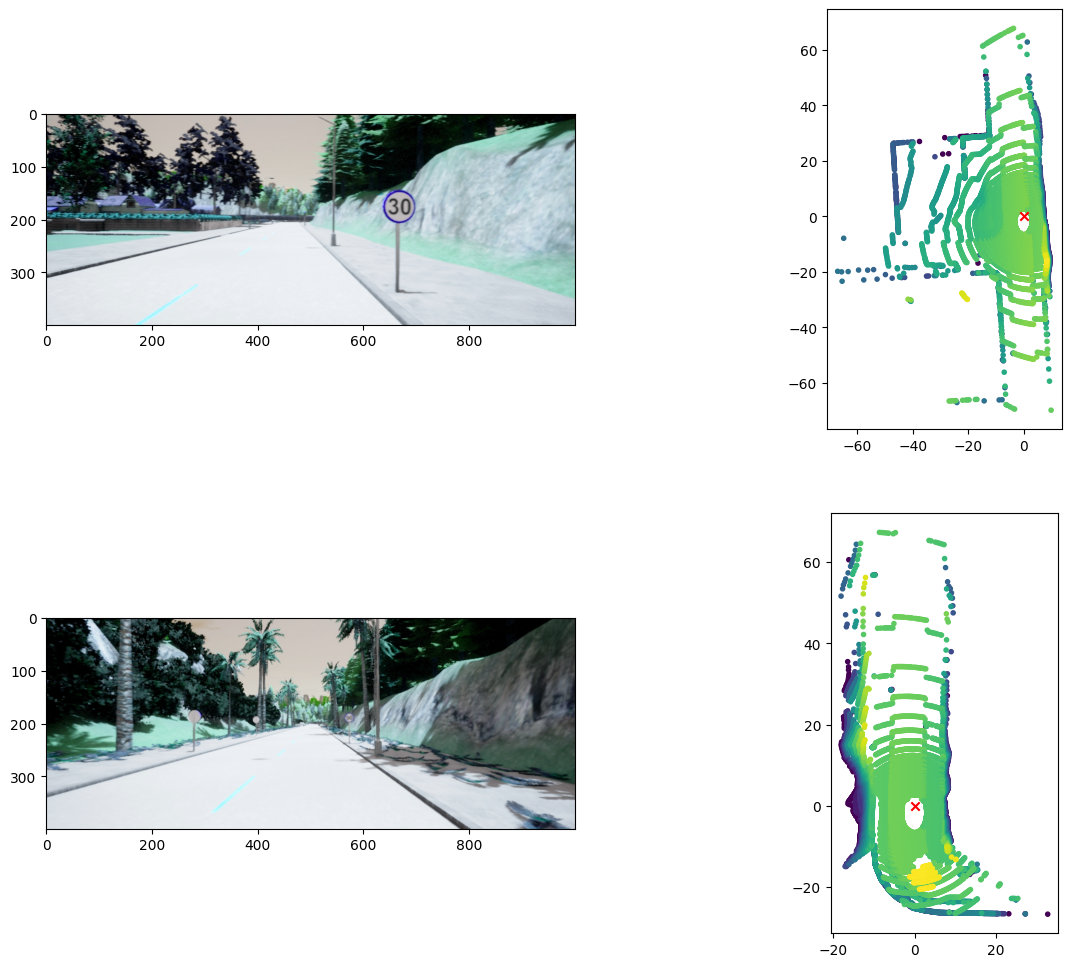

In [ ]:

def load_data(folder_path, timestamp):
    ### Construct the filename using the provided timestamp

    ts = str(timestamp)

    for file_name in os.listdir(os.path.join(folder_path,"rgb")):
        if os.path.splitext(file_name)[0] == ts:
            img_file_path = os.path.join(folder_path, "rgb", file_name)
            print('image_path: ',img_file_path)
            break

    else:
        raise ValueError("Image file not found with the given timestamp.")
    ### Load the image data

    img_raw = cv2.imread(img_file_path)

    ### Load the LiDAR data (only x,y,z data)

    ### Only use LiDAR points that are at least 2.5 m away
    for file_name in os.listdir(os.path.join(folder_path, "Lidar")):
        if  os.path.splitext(file_name)[0] == ts:
            lidar_file_path = os.path.join(folder_path, "Lidar", file_name)
            print('lidar_path: ',lidar_file_path)
            break

    else:
        raise ValueError("lidar file not found with the given timestamp.")


    #lidar_raw = np.loadtxt(lidar_file_path,delimiter=',', dtype=np.float32).reshape(-1, 4)[:, :3]
    lidar_raw=np.load(lidar_file_path).reshape(-1, 4)


    lidar_raw = lidar_raw[lidar_raw[:, 2] <= 0, :]
    dist = np.linalg.norm(lidar_raw, axis=1)
    lidar_raw = lidar_raw[dist >= 3]
    intensity = np.array(lidar_raw[:, 3])
    lidar_raw = lidar_raw[:, :3]
    # Define the radius (in meters)
    radius = 2.7

    # Calculate the Euclidean distance between each point in the point cloud and the lidar sensor position
    distances = np.sqrt((lidar_raw[:, 0])**2 + (lidar_raw[:, 1])**2)

    # Filter out all the points that are within the radius of the lidar sensor position
    lidar_raw = lidar_raw[distances > radius, :]
    return img_raw, lidar_raw, intensity

### Transform the LiDAR points into camera coordinate
def transform_coordinate(lidar_points,l2w_matrix,w2c_matrix):
  inp = lidar_points.copy()
  ones_column = np.ones((inp.shape[0], 1))
  inp=np.concatenate((inp, ones_column), axis=1)



  # Transform the points from lidar space to world space.
  world_points = np.dot(l2w_matrix, inp.T)
  inp = np.dot(w2c_matrix, world_points).T

  '''inp = lidar_points.copy()
  inp = np.concatenate((inp,np.ones((inp.shape[0],1))),axis=1)
  inp = np.matmul(extrinsic_matrix,inp.T).T'''
  return inp[:,:3]

img_raw,lidar_raw, intensity = load_data(folder_path,date1)
img_raw_size = img_raw.shape

lidar_raw = transform_coordinate(lidar_raw,lidar_2_world,world_2_camera)

img_raw1,lidar_raw1 ,intensity1 = load_data(folder_path,date2)
img_raw1_size = img_raw1.shape

lidar_raw1 = transform_coordinate(lidar_raw1,lidar_2_world1,world_2_camera1)

### Visualize
fig,axs = plt.subplots(2,2,figsize=(15,12))
axs[0,0].imshow(img_raw)
axs[0,1].scatter(lidar_raw[:,1],lidar_raw[:,0],c=-lidar_raw[:,2],marker='.')
axs[0,1].scatter(0,0,c='r',marker='x')
axs[0,1].axis('scaled')
axs[1,0].imshow(img_raw1)
axs[1,1].scatter(lidar_raw1[:,1],lidar_raw1[:,0],c=-lidar_raw1[:,2],marker='.')
axs[1,1].scatter(0,0,c='r',marker='x')
axs[1,1].axis('scaled')
plt.show()

In [ ]:
print(lidar_raw.shape)

(24233, 3)


## Project the LiDAR Points to the Camera

To transfer the road information from image to LiDAR, we need to project the LiDAR points to the camera image. Use the camera intrinsic matrix!

The camera intrinsic matrix is denoted as $K$. The coordinate of pixel, $(u,v)$, that represents a point in 3D space, $(X_C,Y_C,Z_C)$, in image frame can be calculated with

\begin{align}
\begin{bmatrix}
u\times w \\
v\times w \\
w \\
\end{bmatrix}=
K
\begin{bmatrix}
X_C \\
Y_C \\
Z_C \\
\end{bmatrix}
\end{align}

<br>
<center><img src="https://docs.opencv.org/4.5.0/pinhole_camera_model.png" width=400px></center>
</br>

Sumber gambar: [OpenCV Docs](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html)

(24233,)
Original image size: (400, 1000, 3)


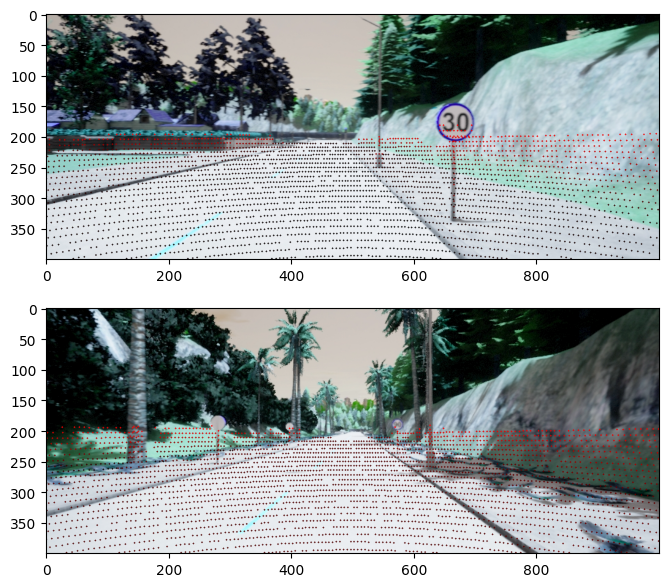

In [ ]:
def project_lidar2cam(lidar_in_cam,camera_intrinsic,img_raw_size):
  ### Filter out data behind the cam

  lidar_in_cam = np.concatenate((lidar_in_cam,np.ones((lidar_in_cam.shape[0],1))),axis=1)

  lidar_in_cam = lidar_in_cam[lidar_in_cam[:,0]>0]

  ### Project points to the image
  point_in_camera_coords=np.array([
                lidar_in_cam[:,1],
                lidar_in_cam[:,2] * -1 ,
                lidar_in_cam[:,0]])
  points_2d = np.matmul(camera_intrinsic,point_in_camera_coords)

  # normalize the x, y values by the 3rd value.
  points_2d = np.array([
                points_2d[0, :] / points_2d[2, :],
                points_2d[1, :] / points_2d[2, :],
                points_2d[2, :]])
  points_2d = points_2d.T
  points_2d = points_2d.astype(int)

  ### Filter out points that are outside image frame
  maskH = np.logical_and(points_2d[:,0]>=0,points_2d[:,0]<img_raw_size[1])
  maskV = np.logical_and(points_2d[:,1]>=0,points_2d[:,1]<img_raw_size[0])
  mask = np.logical_and(maskH,maskV)

  points_2d = points_2d[mask,:]
  lidar_in_cam = lidar_in_cam[mask,:]

  return points_2d,lidar_in_cam[:,:3],mask

lidar_2d,lidar_in_cam ,mask= project_lidar2cam(lidar_raw,camera_intrinsic,img_raw_size)
lidar_2d1,lidar_in_cam1, mask1 = project_lidar2cam(lidar_raw1,camera_intrinsic,img_raw1_size)
print(intensity.shape)

# Extract the screen coords (uv) as integers.
u_coord = lidar_2d[:, 0].astype(int)
v_coord = lidar_2d[:, 1].astype(int)
### Visualize
print(f'Original image size: {img_raw.shape}')

img = img_raw.copy()
axs = 2
axs_log = np.log(lidar_in_cam[:,axs]-np.min(lidar_in_cam[:,axs])+1)
max_axs = np.max(axs_log)
for pt,z in zip(lidar_2d,axs_log):
    color_z = z*255/max_axs
    c = (color_z,0,0)
    cv2.circle(img,tuple(pt[:2].astype(int)),1,c,-1)

img1 = img_raw1.copy()
axs = 2
axs_log1 = np.log(lidar_in_cam1[:,axs]-np.min(lidar_in_cam1[:,axs])+1)
max_axs1 = np.max(axs_log1)
for pt,z in zip(lidar_2d1,axs_log1):
    color_z = z*255/max_axs1
    c = (color_z,0,0)
    cv2.circle(img1,tuple(pt[:2].astype(int)),1,c,-1)

fig,axs = plt.subplots(2,1,figsize=(15,7))
axs[0].imshow(img)
axs[1].imshow(img1)
plt.show()

## Image Cropping

The deep learning model (DeepLab v3+) was trained with cropped images from KITTI dataset with ratio 4:3 (W:H), which was resized further to 513 x 513 images. It will work better if we use the same size of images.

Parameter:
- CROP_RH - The height ratio of target image size
- CROP_RW - The width ratio of target image size

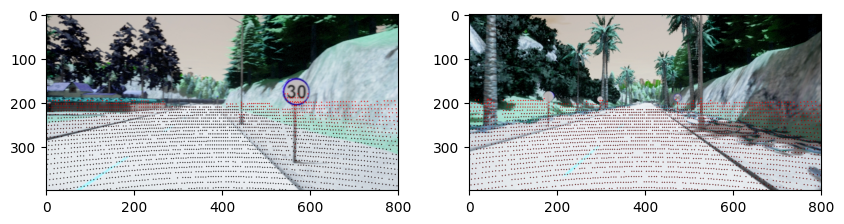

In [ ]:
### Function to crop the image according to the target size ratio
### The image will be cropped at the center
def crop_data(img_in,lidar_2d_in,lidar_in_cam_in,rh,rw):
  lidar_2d = lidar_2d_in.copy()
  lidar_in_cam = lidar_in_cam_in.copy()
  img = img_in.copy()

  ### Crop the image
  dim_ori = np.array(img.shape)
  cent = (dim_ori/2).astype(int)
  if dim_ori[0]/dim_ori[1] == rh/rw:
      crop_img = img

  # If Height <= Width
  elif dim_ori[0] <= dim_ori[1]:
      cH2 = dim_ori[0]
      cW2 = cH2*rw/rh
      cW = int(cW2/2)
      crop_img = img[:,cent[1]-cW:cent[1]+cW+1]

  # If Height > Width
  else:
      cW2 = dim_ori[1]
      cH2 = cW2*rh/rw
      cH = int(cH2/2)
      crop_img = img[cent[0]-cH:cent[0]+cH+1,:]

  ### Filter out LiDAR points outside cropped image
  cW = cW2/2
  cH = cH2/2
  centH = cent[0]
  centW = cent[1]
  maskH = np.logical_and(lidar_2d[:,1]>=centH-cH,lidar_2d[:,1]<=centH+cH)
  maskW = np.logical_and(lidar_2d[:,0]>=centW-cW,lidar_2d[:,0]<=centW+cW)
  mask = np.logical_and(maskH,maskW)
  lidar_2d = lidar_2d[mask,:]
  lidar_in_cam = lidar_in_cam[mask,:]
  cent = np.array((centW-cW,centH-cH,0)).reshape((1,3))
  lidar_2d = lidar_2d - cent

  return crop_img, lidar_2d.astype(int), lidar_in_cam

### Cropped image's size ratio
CROP_RH = 1 # Height ratio
CROP_RW = 2 # Width ratio
crop_img,lidar_2d,lidar_in_cam = crop_data(img_raw,lidar_2d,lidar_in_cam,CROP_RH,CROP_RW)
crop_img1,lidar_2d1,lidar_in_cam1 = crop_data(img_raw1,lidar_2d1,lidar_in_cam1,CROP_RH,CROP_RW)

### Visualize
img = crop_img.copy()
axs = 2
axs_log = np.log(lidar_in_cam[:,axs]-np.min(lidar_in_cam[:,axs])+1)
max_axs = np.max(axs_log)
for pt,z in zip(lidar_2d,axs_log):
    color_z = z*255/max_axs
    c = (color_z,0,0)
    cv2.circle(img,tuple(pt[:2].astype(int)),1,c,-1)

img1 = crop_img1.copy()
axs = 2
axs_log1 = np.log(lidar_in_cam1[:,axs]-np.min(lidar_in_cam1[:,axs])+1)
max_axs1 = np.max(axs_log1)
for pt,z in zip(lidar_2d1,axs_log1):
    color_z = z*255/max_axs1
    c = (color_z,0,0)
    cv2.circle(img1,tuple(pt[:2].astype(int)),1,c,-1)

fig,axs = plt.subplots(1,2,figsize=(10,7))
axs[0].imshow(img)
axs[1].imshow(img1)
plt.show()

## Road Segmentation

Process the camera image with image segmentation-based deep learning method to get regions that correspond to the road. Specifically, we use DeepLab v3+ model that has been trained before with KITTI dataset. The model has been trained on image with size 513 x 513. Thus, the input image need to be resized first before being processed by the model. [Read this article](https://rockyshikoku.medium.com/train-deeplab-v3-with-your-own-dataset-13f2af958a75) if you want to know how to train your own DeepLab v3+ model.

Parameters:
- DEEPLAB_MODEL_PATH - Path to the model protobuff (.pb) file
- DEEPLAB_INPUT_SIZE - Input size of the model

Now, by projecting the LiDAR points to the segmented image, we can know which points that correspond to the road.

<ipython-input-19-72abd2c7c961>:36: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  modes,_ = stats.mode(segm_reg.flatten(),axis=None,nan_policy="omit")


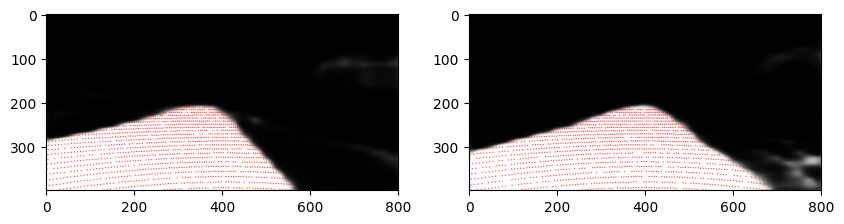

In [ ]:
### Function to process the image with DeepLabv3+
def process_images(img_in, sess, target_size=513, probability_threshold=0.5):
  INPUT_TENSOR_NAME = 'ImageTensor:0'
  PROB_TENSOR_NAME = 'SemanticProbabilities:0'
  INPUT_SIZE = target_size

  image = img_in.copy()
  sz = image.shape
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Resize input image to target size
  if INPUT_SIZE == 0:
    resized_image = image.copy()
  else:
    resized_image = cv2.resize(image,(INPUT_SIZE,INPUT_SIZE))

  # Run deep learning inference
  batch_seg_map = sess.run(
      PROB_TENSOR_NAME,
      feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
  seg_map = (batch_seg_map[0][:,:,1]*255).astype(int)
  prob = np.array(seg_map, dtype=np.uint8)
  prob = cv2.resize(prob,(sz[1],sz[0]))

  # Create the prediction
  pred = prob.copy()
  msk_bin = prob >= (probability_threshold*255)
  pred[msk_bin] = 1
  pred[np.logical_not(msk_bin)] = 0

  # Ignore regions that are separated from the main road
  # This can reduce the amount of false detection
  _,segm_reg = cv2.connectedComponents(pred)
  segm_reg = segm_reg.astype(float)
  segm_reg[segm_reg==0] = np.nan
  modes,_ = stats.mode(segm_reg.flatten(),axis=None,nan_policy="omit")
  mode = modes[0]
  pred[segm_reg!=mode] = 0

  return prob,(pred*255).astype(np.uint8)

### Load the model
DEEPLAB_MODEL_PATH = '/content/drive/MyDrive/s_data/(extra)/deeplab_model.pb'
with open(DEEPLAB_MODEL_PATH, "rb") as f:
    graph_def = tf.compat.v1.GraphDef.FromString(f.read())
graph = tf.Graph()
with graph.as_default():
    tf.import_graph_def(graph_def=graph_def, name="")
sess = tf.compat.v1.Session(graph=graph)

DEEPLAB_INPUT_SIZE = 513
segm_prob,segm_pred = process_images(crop_img, sess, DEEPLAB_INPUT_SIZE, 0.4)
segm_prob1,segm_pred1 = process_images(crop_img1, sess, DEEPLAB_INPUT_SIZE, 0.4)

### Visualize
segm_3ch = crop_img.copy()
segm_3ch[:,:,0] = segm_prob
segm_3ch[:,:,1] = segm_prob
segm_3ch[:,:,2] = segm_prob
for pt in lidar_2d:
  pt = pt.astype(int)
  if segm_pred[pt[1],pt[0]] == 0:
    continue
  c = (255,0,0)
  cv2.circle(segm_3ch,tuple(pt[:2]),1,c,-1)

segm_3ch1 = crop_img1.copy()
segm_3ch1[:,:,0] = segm_prob1
segm_3ch1[:,:,1] = segm_prob1
segm_3ch1[:,:,2] = segm_prob1
for pt in lidar_2d1:
  pt = pt.astype(int)
  if segm_pred1[pt[1],pt[0]] == 0:
    continue
  c = (255,0,0)
  cv2.circle(segm_3ch1,tuple(pt[:2]),1,c,-1)

fig,axs = plt.subplots(1,2,figsize=(10,7))
axs[0].imshow(segm_3ch)
axs[1].imshow(segm_3ch1)
plt.show()

## LiDAR Road Filter

The road points set that are obtained from the previous step may contain false detection and obviously only contains point that are inside the camera field of view. We also need to detect road points that are outside this set!

To do this, fit a plane model (which will represent the road model) $Ax+By+Cz=1$ to the current road points. Any points that are outside the camera field of view and located near the road plane model can be also regarded as road points. RANSAC algorithm is applied when fitting the model to reduce the influence of outliers. Visit this [Wikipedia page](https://en.wikipedia.org/wiki/Random_sample_consensus) for more information about RANSAC.

Parameter:
- ROAD_HEIGHT_THRESHOLD - The maximum distance (in height axis) between a point to the road model to be considered as road point.

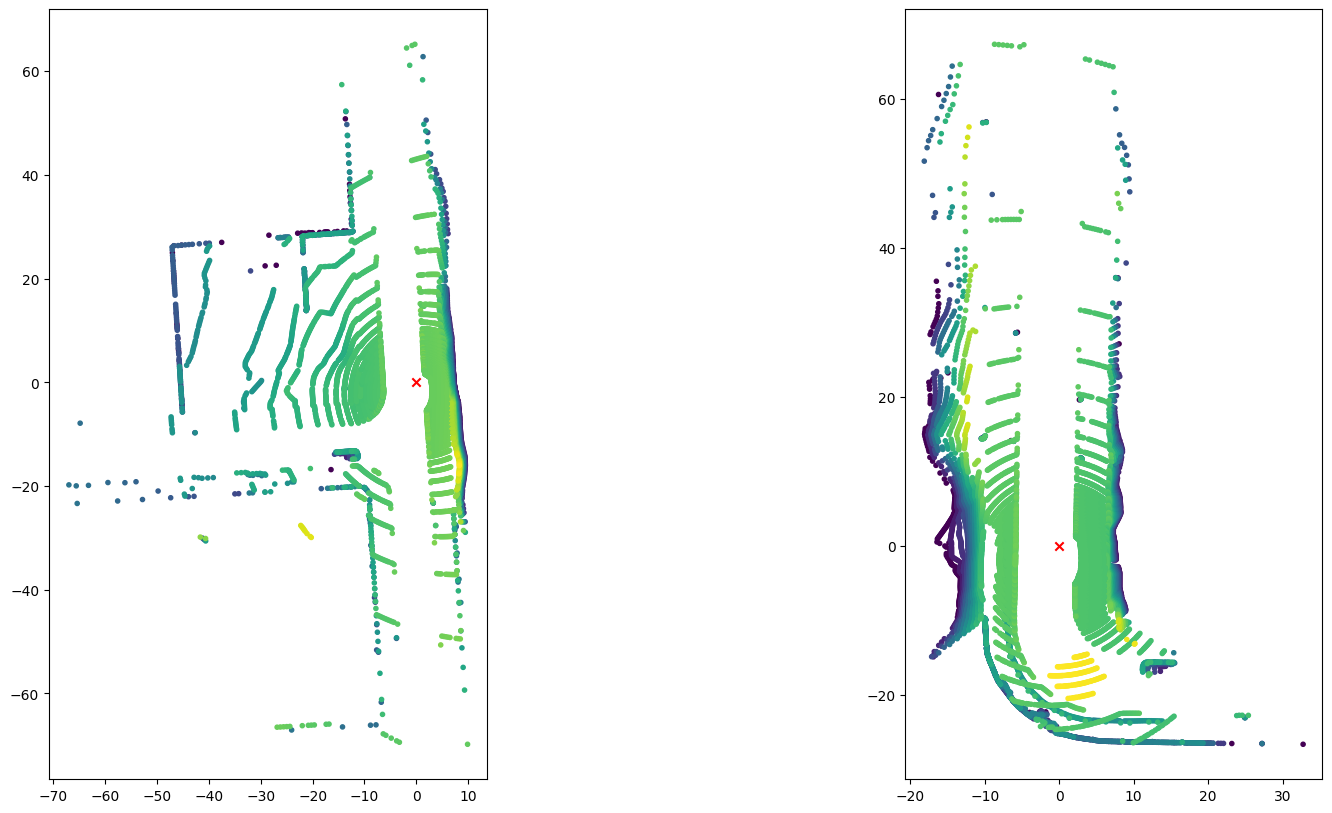

In [ ]:
### Get the plane model from the road points
def get_road_model_ransac(img_pred,lidar_in_cam,lidar_2d):
  lidar_in_road_lbl = [True if img_pred[pt[1],pt[0]] == 255 else False for pt in lidar_2d]
  lidar_in_road = lidar_in_cam[lidar_in_road_lbl,:]
  road_model = RANSACRegressor().fit(lidar_in_road[:,[0,2]],lidar_in_road[:,1])
  return road_model

### Predict all LiDAR points as road or not
def filter_road_points(road_model,lidar_in,threshold=0.5):
  x = lidar_in[:,[0,2]]
  y_true = lidar_in[:,1]
  y_pred = road_model.predict(x)
  delta_y = np.absolute(y_true-y_pred).flatten()
  is_not_road = delta_y > threshold
  lidar_out = lidar_in[is_not_road,:].copy()
  return lidar_out

road_height_threshold = 0.8

road_model = get_road_model_ransac(segm_pred,lidar_in_cam,lidar_2d)
lidar_nonroad = filter_road_points(road_model,lidar_raw,road_height_threshold)

road_model1 = get_road_model_ransac(segm_pred1,lidar_in_cam1,lidar_2d1)
lidar_nonroad1 = filter_road_points(road_model1,lidar_raw1,road_height_threshold)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].scatter(lidar_nonroad[:,1],lidar_nonroad[:,0],c=-lidar_nonroad[:,2],marker='.')
axs[0].scatter(0,0,c='r',marker='x')
axs[0].axis('scaled')
axs[1].scatter(lidar_nonroad1[:,1],lidar_nonroad1[:,0],c=-lidar_nonroad1[:,2],marker='.')
axs[1].scatter(0,0,c='r',marker='x')
axs[1].axis('scaled')
plt.show()

Now we can remove the road points from the LiDAR data and proceed to the mapping system.

# MAPPING (OGM)

The Occupancy Grid Map (OGM) in this tutorial is estimated with the procedure described in [4]. OGM is a grid-based (image-like) map where each of its cell/pixel contains probability of that cell occupied by any obstacle.

## Parameters

There are several parameters that need to be defined:
- ALPHA - The radial resolution when converting LiDAR data to grid map in m (explained later).
- BHETA - The angular resolution when converting LiDAR data to grid map in radian (explained later) .
- RESOLUTION - The resolution of the grid map in m.
- MAX_RANGE - Maximum range of LiDAR points that will be converted to grid map.
- MAP_WIDTH - Width of the map from side to side in m.
- SPHERICAL2CARTESIAN_BIAS - An adjustment needed due to some errors when converting the spherical grid map to the cartesian grid map.

In [ ]:
ALPHA = 1
BHETA = 1*np.pi/180
RESOLUTION = 0.1
MAX_RANGE = 50
MAP_WIDTH = 100
SPHERICAL2CARTESIAN_BIAS = 6

## Map Initialization

The OGM is initialized with probability of all of its cells = 0.5

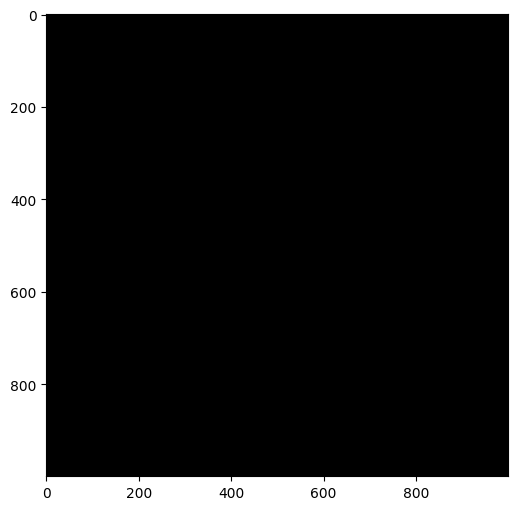

In [ ]:
### Some derived parameters
# OOR_MASK = A mask to filter out measurements that are out of MAX_RANGE
MAP_SIZE_X = int(MAP_WIDTH/RESOLUTION)
MAP_SIZE_Y = int(MAP_WIDTH/RESOLUTION)
xarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
yarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
MAP_XX, MAP_YY = np.meshgrid(xarr, -yarr)
rgrid = np.sqrt(np.add(np.square(MAP_XX),np.square(MAP_YY)))
OOR_MASK = rgrid >= MAX_RANGE

### Initialize OGM
ogm_time_0 = np.ones((MAP_SIZE_Y,MAP_SIZE_X)) * 0.5

### Only use the x-z axis of the point (ignore the height axis)
lidar_ogm = lidar_nonroad[:,[0,1]]
lidar_ogm1 = lidar_nonroad1[:,[0,1]]

### Visualize
# Yes, it's still empty
plt.figure(figsize=(6, 6))
plt.imshow(ogm_time_0,cmap='gray',vmax=1)
plt.show()

## Generate Measurement Grid from Filtered LiDAR

To update the OGM with the most recent measurement, the LiDAR points need to be converted to the similar grid format. This grid is called the scan grid (SG).

Take a look at the figure of a SG below. In the figure, the purple point is a sample of the LiDAR measurements. There are three conditions to fill the SG.
1. Black cells: The cells around the point (cells that are radially located at +-ALPHA and angularly located at +-BHETA from the point) are given probability = 0.7 which means that they are likely to be occupied.
2. White cells: The cells that are located between the origin/sensor and the measured point are given probability = 0.3 which means that they are likely to be free.
3. Gray cells: The other cells, including the ones behind the points, are given probability = 0.5 which means that we can't infer whether they are free or occupied.

<br>
<center><img src="https://github.com/MukhlasAdib/KITTI_Mapping/blob/main/figures/sg_gen.png?raw=true" width=300px></center>
</br>

The efficient implementation of the SG creation is not straightforward. In this tutorial, we create the SG in spherical coordinate first. After the spherical SG is filled, then it is converted to cartesian coordinate. I recommend you to read the procedure of scan grid generation in [5].

[[0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 ...
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]]
[[0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 ...
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]]


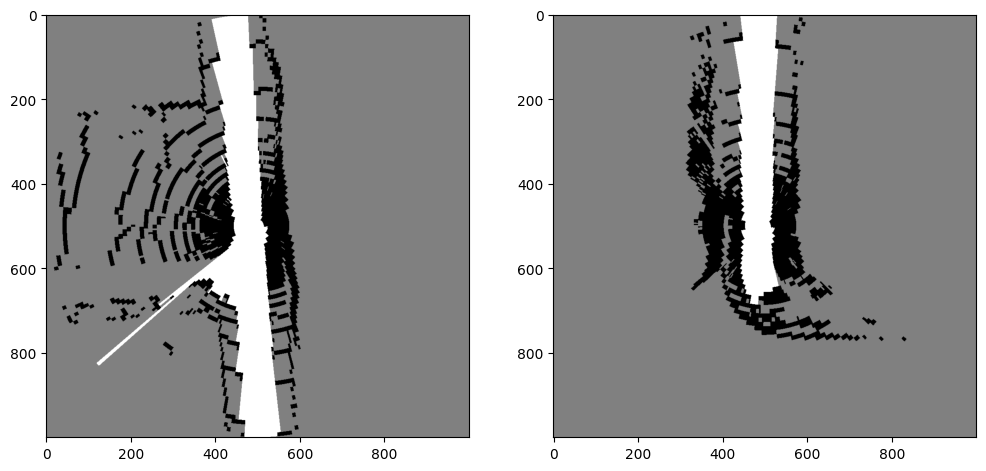

In [ ]:
def generate_measurement_ogm(lidar_in,ogm_shape):
  ### Calculate the position of LiDAR points in spherical coordinate
  rphi_meas = np.zeros((lidar_in.shape[0],2))
  rphi_meas[:,1] = np.sqrt(np.add(np.square(lidar_in[:,0]),np.square(lidar_in[:,1])))/ALPHA
  rphi_meas[:,0] = (np.arctan2(lidar_in[:,1],lidar_in[:,0])+np.pi)/BHETA
  rphi_meas = np.unique(rphi_meas.astype(int),axis=0)
  rphi_meas = rphi_meas[rphi_meas[:,1]<int(MAX_RANGE/ALPHA),:]
  rphi_meas = rphi_meas[rphi_meas[:,0]<int(2*np.pi/BHETA),:]

  ### Initiate and fill the spherical scan grid
  sg_ang_bin = int(2*np.pi/BHETA)
  sg_rng_bin = int(MAX_RANGE/ALPHA)
  # Initiation (Condition 3)
  scan_grid = np.ones((sg_ang_bin,sg_rng_bin))*0.5
  # Condition 1
  scan_grid[tuple(rphi_meas.T)] = 0.7
  # Condition 2
  for ang in range(sg_ang_bin):
    ang_arr = rphi_meas[rphi_meas[:,0]==ang,1]
    if len(ang_arr) == 0:
      scan_grid[ang,:] = 0.3
    else:
      min_r = np.min(ang_arr)
      scan_grid[ang,:min_r] = 0.3

  ### Convert the spherical scan grid to the cartesian one
  ogm_sz = (ogm_shape[1],ogm_shape[0])
  ogm_cen = (int(ogm_shape[1]/2),int(ogm_shape[0]/2))
  radius = (MAX_RANGE/RESOLUTION) + SPHERICAL2CARTESIAN_BIAS
  ogm_step = cv2.warpPolar(scan_grid,ogm_sz,ogm_cen,radius,cv2.WARP_INVERSE_MAP)
  ogm_step[OOR_MASK] = 0.5
  ogm_step = cv2.rotate(ogm_step, cv2.ROTATE_90_CLOCKWISE)
  print(ogm_step)
  return ogm_step

ogm_step = generate_measurement_ogm(lidar_ogm,ogm_time_0.shape)
ogm_step1 = generate_measurement_ogm(lidar_ogm1,ogm_time_0.shape)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm_step)*255).astype(np.uint8),cmap='gray')
axs[1].imshow(((1-ogm_step1)*255).astype(np.uint8),cmap='gray')
plt.show()